In [10]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# import dataset
df = pd.read_csv('time_series_dataframe.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)

# convert date column into datetime
df.date = pd.to_datetime(df.date)

# set date column to index
df.set_index('date', inplace=True)

In [12]:
df

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2017-04-20,34.500000,27.500000,5.562500,998.625000
2017-04-21,34.250000,39.375000,6.962500,999.875000
2017-04-22,32.900000,40.900000,8.890000,1001.600000


### EDA

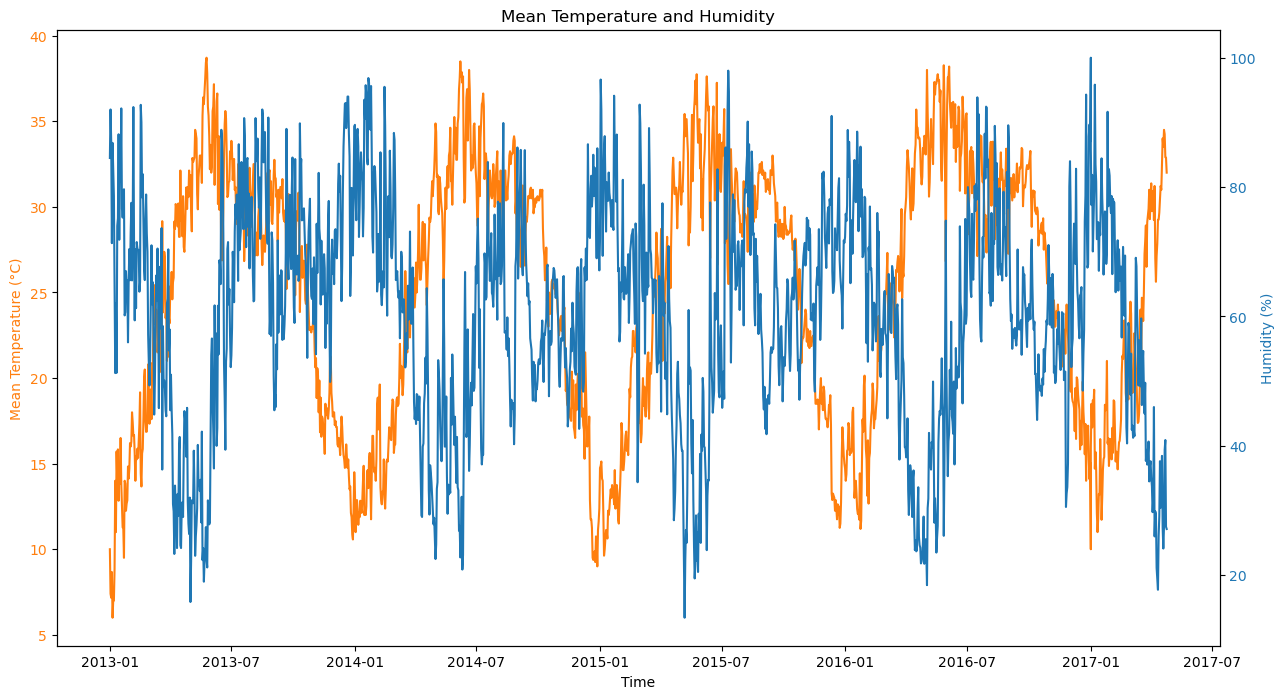

In [17]:
# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(15, 8))

# Plot the first y-axis (meantemp)
color = 'tab:orange'
ax1.set_xlabel('Time')
ax1.set_ylabel('Mean Temperature (°C)', color=color)
ax1.plot(df['meantemp'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis sharing the same x-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Humidity (%)', color=color)
ax2.plot(df['humidity'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.title('Temperature and Humidity')
plt.show()

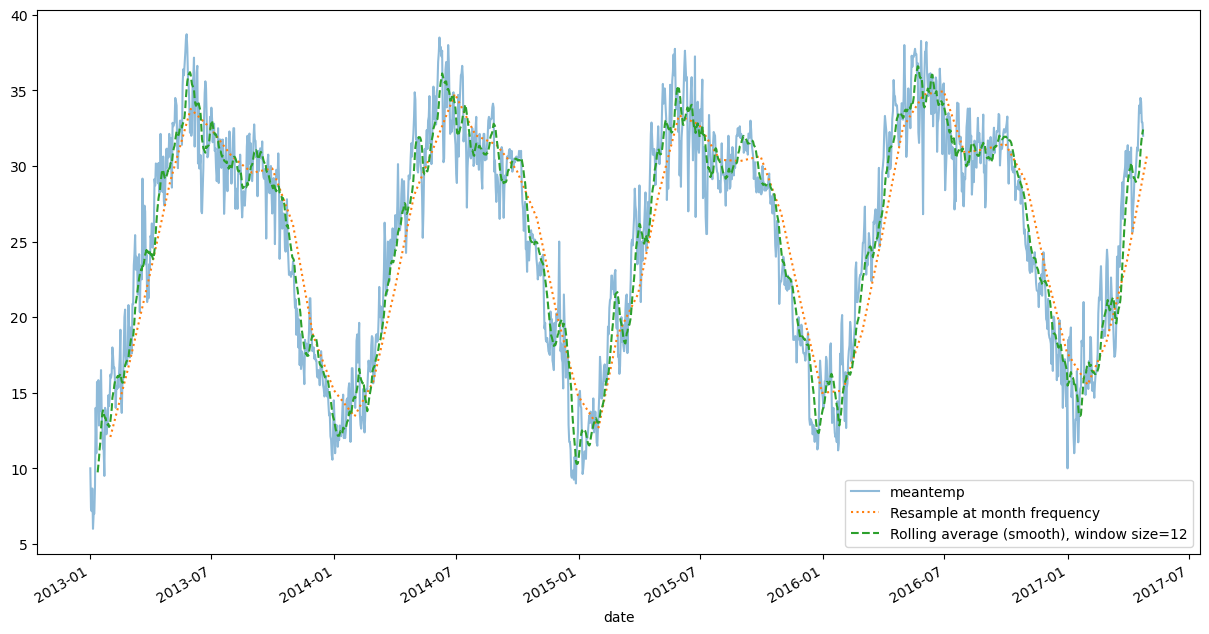

In [23]:
## smooth temperature

temperature = df.meantemp
temp_resamp_month = temperature.resample('M').mean()
temp_roll_yr = temperature.rolling(12).mean()

fig, ax = plt.subplots(figsize=(15, 8))
ax = temperature.plot(alpha=0.5, style='-') # store axis (ax) for latter plots
temp_resamp_month.plot(style=':', label='Resample at month frequency', ax=ax)
temp_roll_yr.plot(style='--', label='Rolling average (smooth), window size=12', ax=ax)
ax.legend()

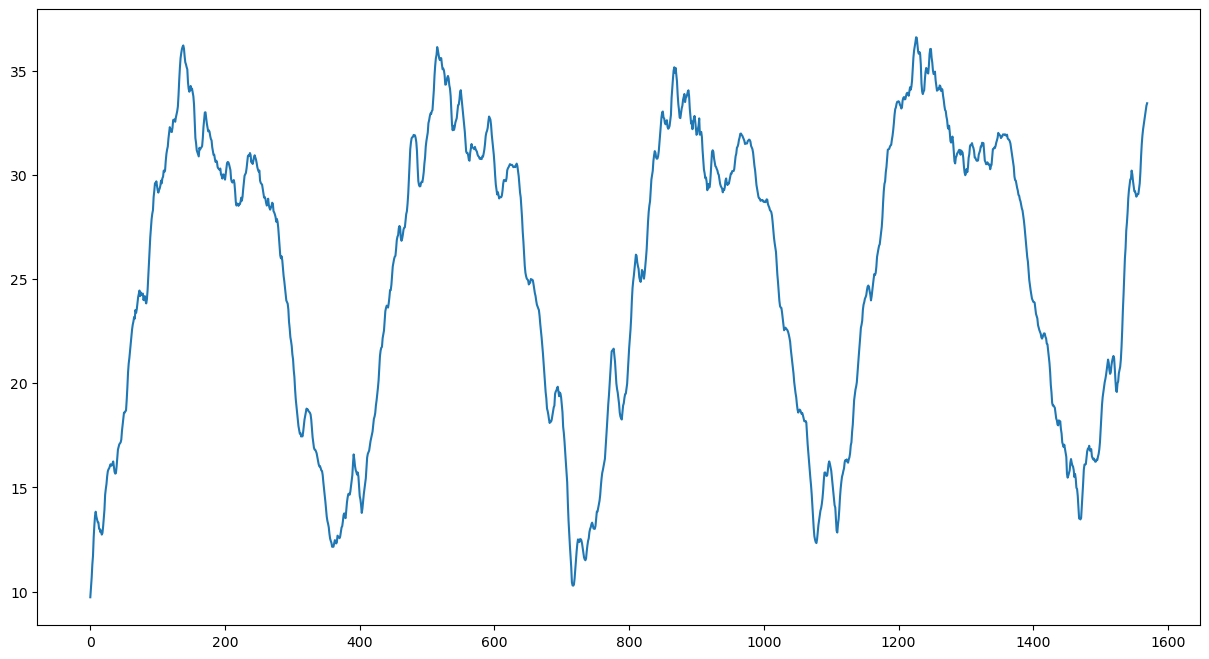

In [31]:
# Alternative smoothing technique with numpy

fig, ax = plt.subplots(figsize=(15, 8))

x = np.asarray(df[['meantemp']])
win = 12
win_half = int(win / 2)
t_smooth = np.array([x[(idx-win_half):(idx+win_half)].mean() for idx in np.arange(win_half, len(x))])
plt.plot(t_smooth)

Text(0.5, 0, 'Year')

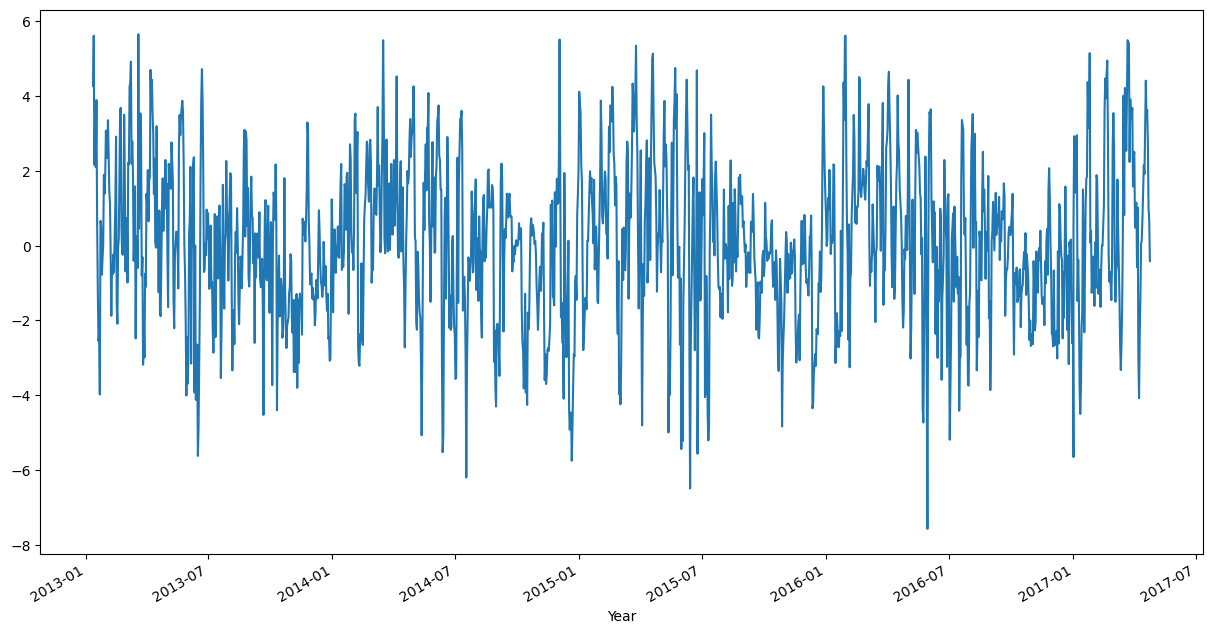

In [37]:
# Detrending
temp_df = df.copy()
temperature = df.meantemp
temp_df = temp_df[['meantemp']]
temp_df['smooth_temp'] = temperature.rolling(12).mean()

fig, ax = plt.subplots(figsize=(15, 8))

d_trend = temp_df['meantemp'] - temp_df['smooth_temp']
d_trend.plot()
plt.xlabel('Year')

Text(0.5, 0, 'Year')

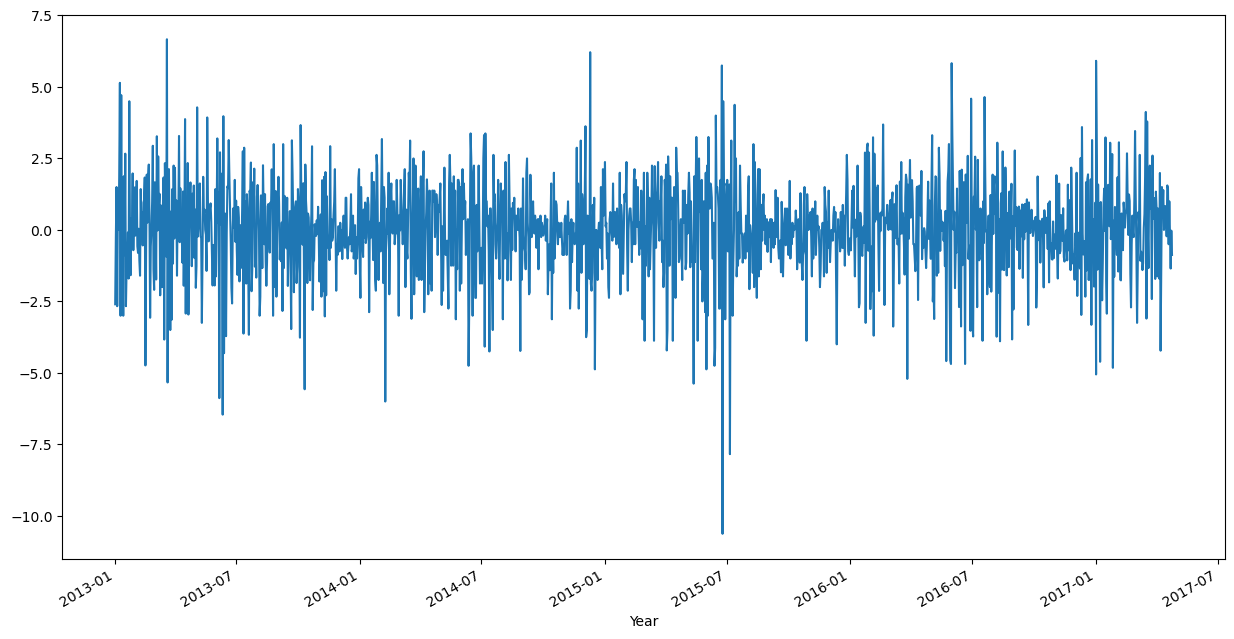

In [40]:
# First-Order differencing
fig, ax = plt.subplots(figsize=(15, 8))

df.meantemp.diff().plot()
plt.xlabel('Year')

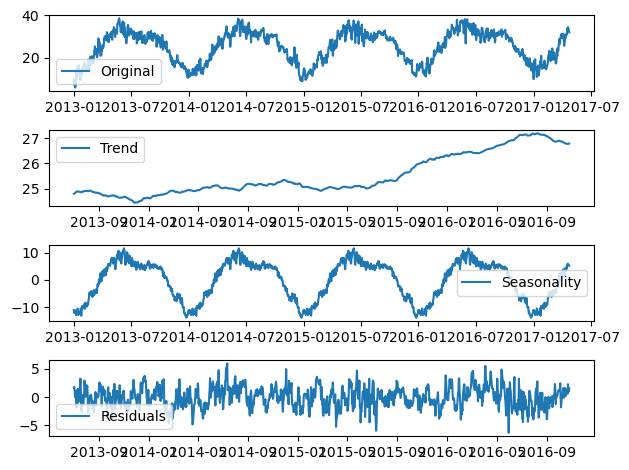

In [62]:
# Decomposing a time series - Yearly
from statsmodels.tsa.seasonal import seasonal_decompose 

x = df.meantemp

x = x.astype(float) # force float
decomposition = seasonal_decompose(x, period = 365)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

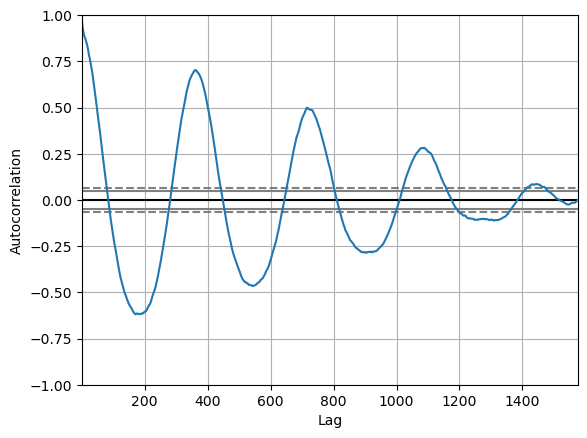

In [63]:
# Autocorrelation 

from pandas.plotting import autocorrelation_plot

x = df.meantemp

autocorrelation_plot(x)

Text(0.5, 1.0, 'Autocorrelation Function')

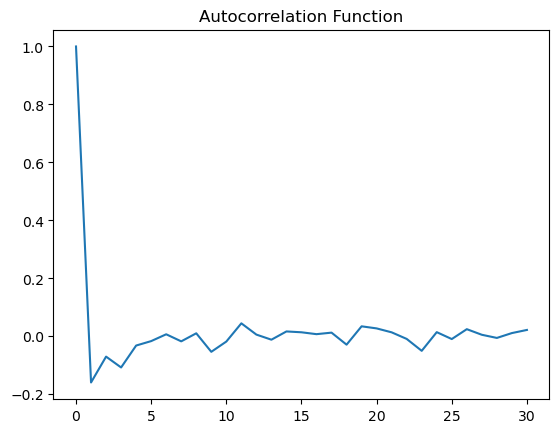

In [68]:
# Compute autocorrelation function 
from statsmodels.tsa.stattools import acf
x_diff = x.diff().dropna() # first item is NA
lag_acf = acf(x_diff, nlags=30)
plt.plot(lag_acf)
plt.title('Autocorrelation Function')

### Forecasting using ARIMA

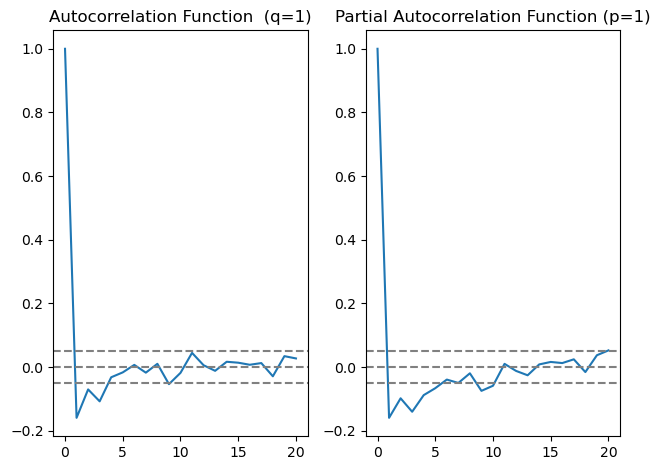

In [69]:
from statsmodels.tsa.stattools import acf, pacf

x = df["meantemp"].astype(float)
x_diff = x.diff().dropna() # first item is NA
# ACF and PACF plots:
lag_acf = acf(x_diff, nlags=20)
lag_pacf = pacf(x_diff, nlags=20, method='ols')
#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function  (q=1)')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function (p=1)')
plt.tight_layout()

/Users/gianlucascibilia/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gianlucascibilia/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/gianlucascibilia/opt/anaconda3/envs/datascience/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1576
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2993.895
Date:                Sat, 23 Dec 2023   AIC                           5993.790
Time:                        23:26:52   BIC                           6009.876
Sample:                             0   HQIC                          5999.768
                               - 1576                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5854      0.045     13.053      0.000       0.498       0.673
ma.L1         -0.8066      0.035    -22.898      0.000      -0.876      -0.738
sigma2         2.6216      0.071     36.762      0.0

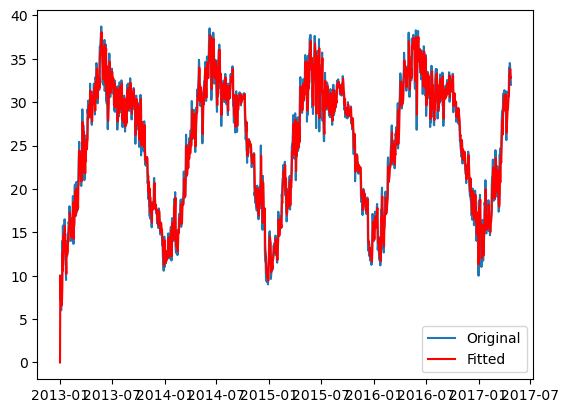

In [74]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA model
model = ARIMA(x, order=(1, 1, 1)).fit()

# Display model summary
print(model.summary())

# Plot the time series and the fitted values
plt.plot(x, label='Original')
plt.plot(model.fittedvalues, color='red', label='Fitted')
plt.legend()
plt.show()